In [1]:
import dwdatareader as dw
import matplotlib.pyplot as plt 
import noisereduce as nr
from IPython.display import Audio
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift, rfft, rfftfreq
from scipy.signal import butter,filtfilt
import numpy as np
import acoustics.signal as S
import pandas as pd
import re
import os
import librosa as l
import scipy
import PyOctaveBand
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import scikitplot as skplt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge
from sklearn.model_selection import learning_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn import mixture
from sklearn.svm import SVC
import more_itertools as mit
import seaborn as sns
import math
import os
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from scipy import stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from scipy.fftpack import dct
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from numpy import percentile
from model import machine
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import RocCurveDisplay
import scikitplot as skplt
from sklearn.metrics import f1_score
from mlxtend.evaluate import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support
import random


c:\Users\anand\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def train_model(train_data, train_label,model_name):
    if model_name=='Random':
        num_trees = 1066 #1000
        max_depth = 98 #100
        model = RandomForestClassifier(n_estimators=num_trees, max_depth=max_depth, min_samples_split=5, criterion="entropy", verbose=0,class_weight='balanced')
        model.fit(train_data, train_label)
    elif model_name=='SVM':
        gamma=1
        C=10
        model=SVC(kernel='rbf',gamma=gamma, C=C,probability=True)
        model.fit(train_data, train_label)
    elif model_name=='Autoencoder':
        print("Autoencoder")
    return model
    
def evaluation_matrix(model, train_data, train_label, test_data, test_label):
    cM=metrics.confusion_matrix(test_label, model.predict(test_data))
    print("Confusion matrix \n",cM)

    bal_accuracy= balanced_accuracy_score(test_label, model.predict(test_data))
    print("Balance Accuracy=",bal_accuracy)
    print("Class wise accuracy",cM.diagonal()/cM.sum(axis=1))
    print("Per class accuracy class 1", accuracy_score(test_label, model.predict(test_data),method='binary', pos_label=1))
    print("Per class accuracy class 0", accuracy_score(test_label, model.predict(test_data),method='binary', pos_label=0))
    print("average per class  accuracy", accuracy_score(test_label, model.predict(test_data),method='average'))

    cR=metrics.classification_report(test_label, model.predict(test_data))
    print("ClassificationReport \n",cR)   

    cv = StratifiedKFold(n_splits=5,random_state=11,shuffle=True) # Creating a StratifiedKFold object with 5 folds
    scores = cross_val_score(model,train_data, train_label, cv=cv,scoring="accuracy")
    print('Scores',scores, np.average(scores))

    f1_weighted_1=f1_score(test_label, model.predict(test_data),average='weighted')
    print("F1 weighted",f1_weighted_1)#,f1_weighted_0)
    print("Precison weighted", precision_score(test_label, model.predict(test_data),labels=[1,0] ,average='weighted'))
    print("recall weighted", recall_score(test_label, model.predict(test_data),labels=[1,0] ,average='weighted'))

    print("Confusion matrix \n")
    ConfusionMatrixDisplay.from_predictions(test_label, model.predict(test_data))
    plt.show()
   
    rf_disp = RocCurveDisplay.from_estimator(model, test_data, test_label)
    plt.show()

    fig, ax = plt.subplots(1,2,figsize=(15,6))
    pr = skplt.metrics.plot_precision_recall(test_label, model.predict_proba(test_data),ax=ax[1])
    roc = skplt.metrics.plot_roc(test_label, model.predict_proba(test_data),ax=ax[0])
    plt.show()
    
def undersampling(train_data, train_label):
    rus = RandomUnderSampler()
    undersample_data,undersample_label=rus.fit_resample(train_data, train_label)
    print("Length of train: ", len(undersample_data),"Length of label :", len(undersample_label))
    unique, counts = np.unique(undersample_label, return_counts=True)
    d3=dict(zip(unique, counts))
    print(f"Numbers of class instances (Undersampling): {d3}")
    return undersample_data, undersample_label

def normalize_data(data):
    norm_time=MinMaxScaler()
    norm_time.fit(data.iloc[:,:-1])
    norm_data=norm_time.transform(data.iloc[:,:-1])
    norm_data=pd.concat([pd.DataFrame(norm_data),data.iloc[:,-1:]],axis=1)

    label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
    data=np.array(norm_data.iloc[:,:-1])
    
    unique, counts = np.unique(label, return_counts=True)
    d=dict(zip(unique, counts))
    print(f"Numbers of class instances (Raw): {d}")
    return norm_data
    
def split_data(data,label):
    indices = np.arange(len(data))
    x_train, x_test, y_train, y_test,indices_train,indices_test= train_test_split(data, label, indices, test_size=0.2,random_state=20,shuffle=True)
    return x_train, x_test, y_train, y_test,indices_train,indices_test
def learning_curve_plot(model,data,label,model_name):
    if model_name=='Random':
        num_trees = 1066 #1000
        max_depth = 98 #100
        model = RandomForestClassifier(n_estimators=num_trees, max_depth=max_depth, min_samples_split=5, criterion="entropy", verbose=0,class_weight='balanced')
    elif model_name=='SVM':
        gamma=1
        C=10
        model=SVC(kernel='rbf',gamma=gamma, C=C,probability=True)
    train_size=[]    
    datasize=int(data.shape[0]*0.8)
    for i in range(0,5):
        train_size.append(random.randint(1,datasize))
    train_size.sort()

    train_sizes,train_scores,validation_scores=learning_curve(estimator=model, X=data, y=label, train_sizes=train_size, cv = 5, scoring = 'balanced_accuracy')

    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)
    # print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
    # print('\n', '-' * 20) # separator
    # print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))
    plt.style.use('seaborn')
    plt.plot(train_sizes, train_scores_mean, label = 'Training Accuracy')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation Accuracy')
    plt.ylabel('Accuracy', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning curves for '+model_name, fontsize = 18, y = 1.03)
    plt.legend()
    plt.show()

# II TIME

file path-------------- ../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/Time/II.csv -------------
Numbers of class instances (Raw): {0: 1175, 1: 18318}
Numbers of class instances (Raw): {0: 1175, 1: 18318}
Length of train:  15594 Length of test : 3899
Numbers of class instances (Train): {0: 951, 1: 14643}
Numbers of class instances (Test): {0: 224, 1: 3675}
Length of train:  1902 Length of label : 1902
Numbers of class instances (Undersampling): {0: 951, 1: 951}
---------------Train Random forest----------------
Confusion matrix 
 [[ 178   46]
 [1341 2334]]
Balance Accuracy= 0.7148724489795918
Class wise accuracy [0.79464286 0.63510204]
Per class accuracy class 1 0.6442677609643498
Per class accuracy class 0 0.6442677609643498
average per class  accuracy 0.6442677609643498
ClassificationReport 
               precision    recall  f1-score   support

           0       0.12      0.79      0.20       224
           1       0.98      0.64      0.77      3675

   

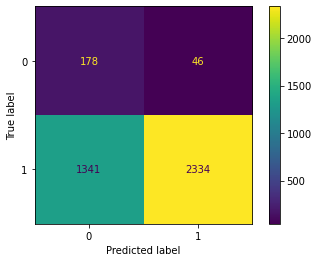

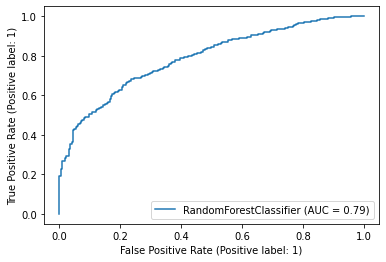

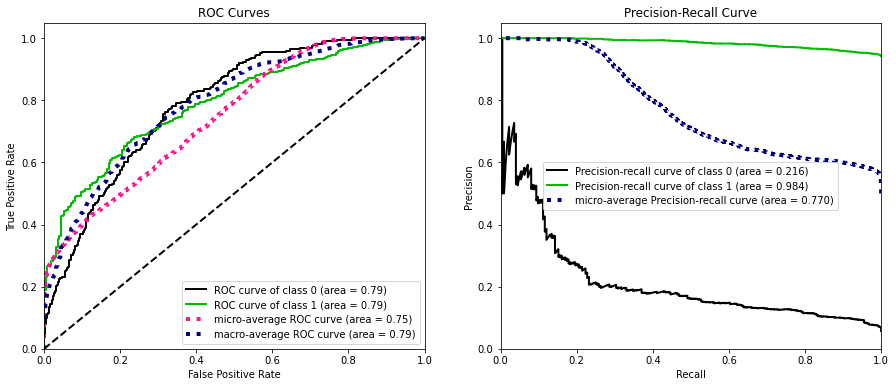

-------------------Train SVM----------------------
Confusion matrix 
 [[ 189   35]
 [1708 1967]]
Balance Accuracy= 0.6894940476190476
Class wise accuracy [0.84375   0.5352381]
Per class accuracy class 1 0.5529622980251346
Per class accuracy class 0 0.5529622980251346
average per class  accuracy 0.5529622980251346
ClassificationReport 
               precision    recall  f1-score   support

           0       0.10      0.84      0.18       224
           1       0.98      0.54      0.69      3675

    accuracy                           0.55      3899
   macro avg       0.54      0.69      0.44      3899
weighted avg       0.93      0.55      0.66      3899

Scores [0.69028871 0.7007874  0.7        0.68947368 0.7       ] 0.6961099599392181
F1 weighted 0.6633987096429727
Precison weighted 0.931795099108792
recall weighted 0.5529622980251346
Confusion matrix 



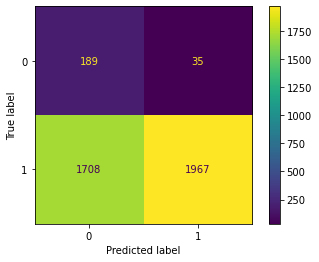

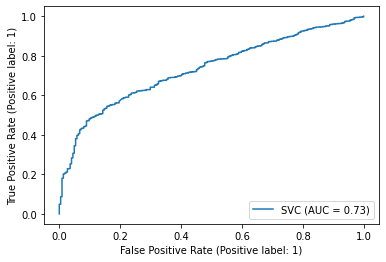

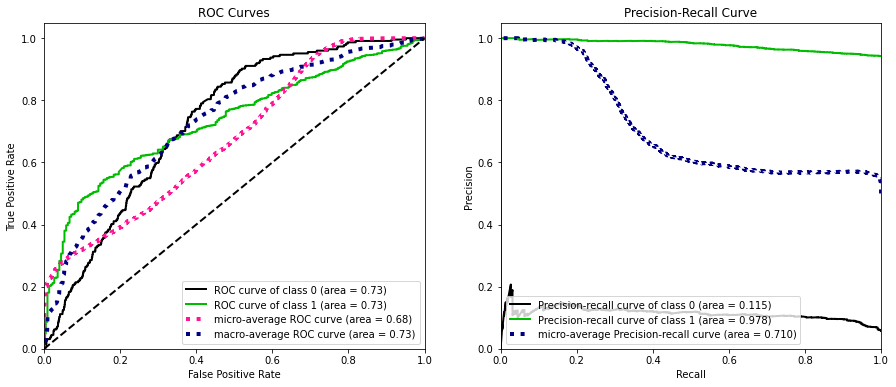

In [3]:
time_col_list=['Peak','energy','impulse_factor','kurtosis_factor','clearance_factor','square_root_mean','root_mean_square','kurtosis','margin_factor','crest_factor','skewness','peak_to_peak_value','shape_factor','mean','variance','distance','zero_cross','avg_rotation','avg_force','label']
filepath='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/Time/II.csv'
print("file path--------------",filepath,"-------------")
df=pd.read_csv(filepath)
df.columns=time_col_list

new_df=df[['avg_rotation','avg_force','root_mean_square','energy','distance','zero_cross','variance','label']]

## Normalize data
norm_data= normalize_data(new_df)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)

print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)


# III TIME

file path-------------- ../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/Time/III.csv -------------
Numbers of class instances (Raw): {0: 6400, 1: 538}
Numbers of class instances (Raw): {0: 6400, 1: 538}
Length of train:  5550 Length of test : 1388
Numbers of class instances (Train): {0: 5126, 1: 424}
Numbers of class instances (Test): {0: 1274, 1: 114}
Length of train:  848 Length of label : 848
Numbers of class instances (Undersampling): {0: 424, 1: 424}
---------------Train Random forest----------------
Confusion matrix 
 [[1011  263]
 [  33   81]]
Balance Accuracy= 0.7520449475336694
Class wise accuracy [0.79356358 0.71052632]
Per class accuracy class 1 0.7867435158501441
Per class accuracy class 0 0.7867435158501441
average per class  accuracy 0.7867435158501441
ClassificationReport 
               precision    recall  f1-score   support

           0       0.97      0.79      0.87      1274
           1       0.24      0.71      0.35       114

    accura

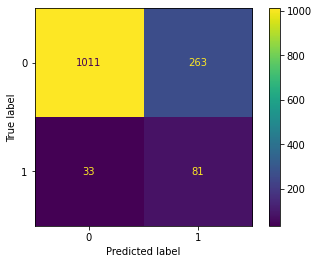

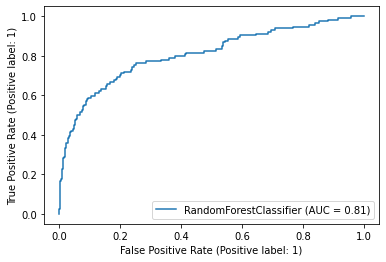

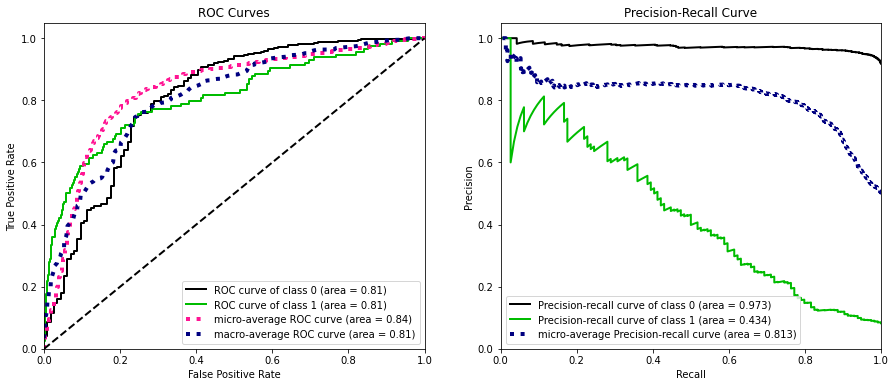

-------------------Train SVM----------------------
Confusion matrix 
 [[819 455]
 [ 40  74]]
Balance Accuracy= 0.6459899749373434
Class wise accuracy [0.64285714 0.64912281]
Per class accuracy class 1 0.6433717579250721
Per class accuracy class 0 0.6433717579250721
average per class  accuracy 0.6433717579250721
ClassificationReport 
               precision    recall  f1-score   support

           0       0.95      0.64      0.77      1274
           1       0.14      0.65      0.23       114

    accuracy                           0.64      1388
   macro avg       0.55      0.65      0.50      1388
weighted avg       0.89      0.64      0.72      1388

Scores [0.61764706 0.62352941 0.63529412 0.68047337 0.59171598] 0.6297319874695441
F1 weighted 0.7237647650533116
Precison weighted 0.8866154709427602
recall weighted 0.6433717579250722
Confusion matrix 



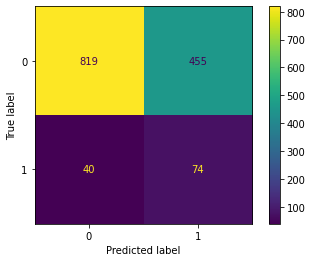

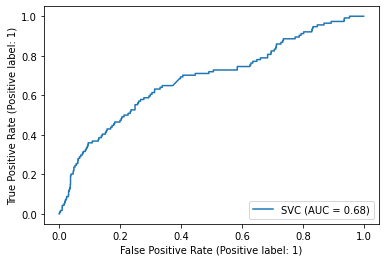

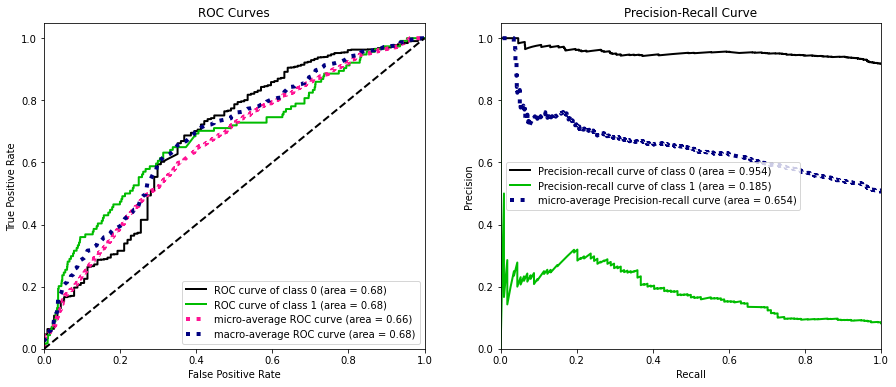

In [4]:
time_col_list=['Peak','energy','impulse_factor','kurtosis_factor','clearance_factor','square_root_mean','root_mean_square','kurtosis','margin_factor','crest_factor','skewness','peak_to_peak_value','shape_factor','mean','variance','distance','zero_cross','avg_rotation','avg_force','label']
filepath='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/Time/III.csv'
print("file path--------------",filepath,"-------------")
df=pd.read_csv(filepath)
df.columns=time_col_list

new_df=df[['avg_rotation','avg_force','root_mean_square','energy','distance','zero_cross','variance','label']]

## Normalize data
norm_data= normalize_data(new_df)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)
print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)

# IV TIME

file path-------------- ../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/Time/IV.csv -------------
Numbers of class instances (Raw): {0: 16950, 1: 2651}
Numbers of class instances (Raw): {0: 16950, 1: 2651}
Length of train:  15680 Length of test : 3921
Numbers of class instances (Train): {0: 13564, 1: 2116}
Numbers of class instances (Test): {0: 3386, 1: 535}
Length of train:  4232 Length of label : 4232
Numbers of class instances (Undersampling): {0: 2116, 1: 2116}
---------------Train Random forest----------------
Confusion matrix 
 [[2545  841]
 [ 147  388]]
Balance Accuracy= 0.7384289901794636
Class wise accuracy [0.75162434 0.72523364]
Per class accuracy class 1 0.7480234634021933
Per class accuracy class 0 0.7480234634021933
average per class  accuracy 0.7480234634021933
ClassificationReport 
               precision    recall  f1-score   support

           0       0.95      0.75      0.84      3386
           1       0.32      0.73      0.44       535



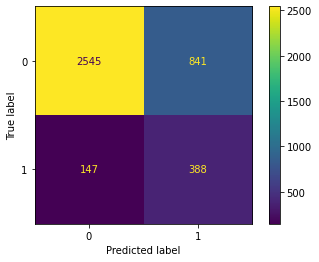

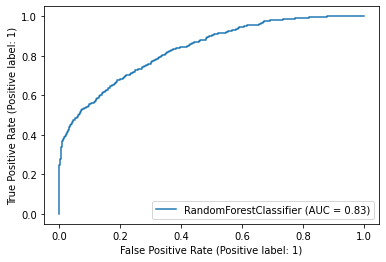

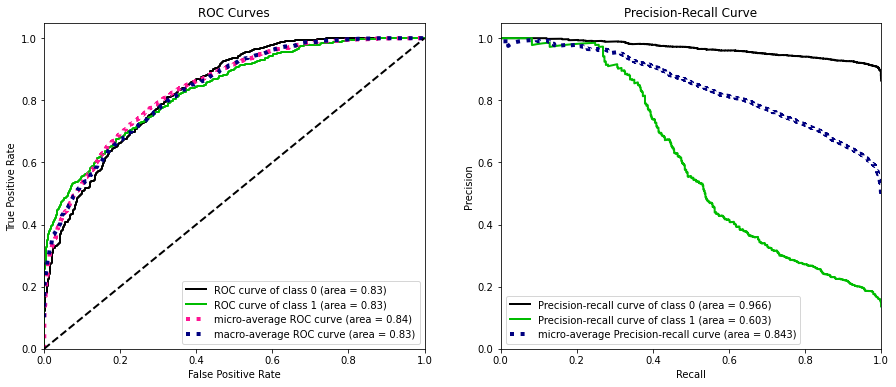

-------------------Train SVM----------------------
Confusion matrix 
 [[3054  332]
 [ 298  237]]
Balance Accuracy= 0.6724699284022722
Class wise accuracy [0.9019492  0.44299065]
Per class accuracy class 1 0.8393267023718439
Per class accuracy class 0 0.8393267023718439
average per class  accuracy 0.8393267023718439
ClassificationReport 
               precision    recall  f1-score   support

           0       0.91      0.90      0.91      3386
           1       0.42      0.44      0.43       535

    accuracy                           0.84      3921
   macro avg       0.66      0.67      0.67      3921
weighted avg       0.84      0.84      0.84      3921

Scores [0.65289256 0.63990555 0.67730496 0.6713948  0.64539007] 0.6573775890990592
F1 weighted 0.8413954589455581
Precison weighted 0.8436153123689107
recall weighted 0.8393267023718439
Confusion matrix 



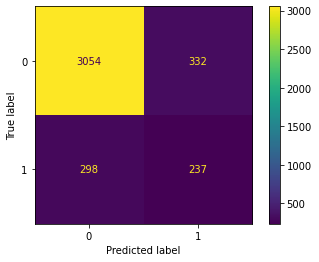

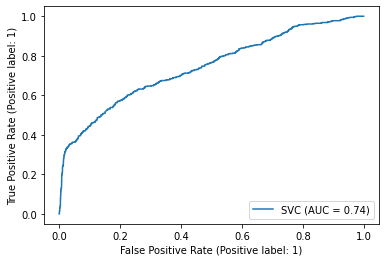

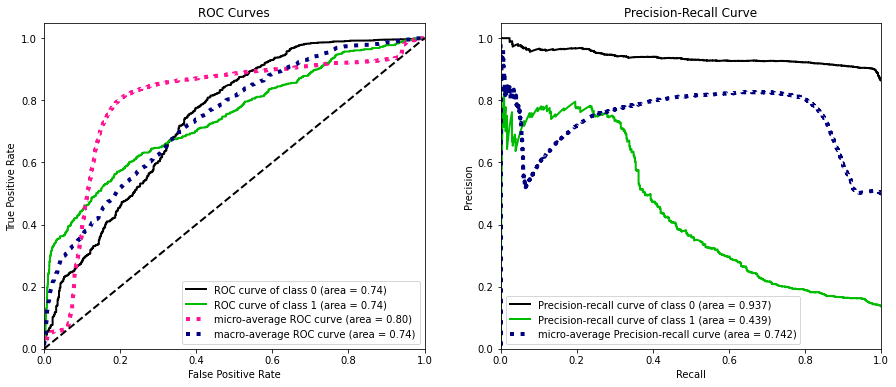

In [5]:
time_col_list=['Peak','energy','impulse_factor','kurtosis_factor','clearance_factor','square_root_mean','root_mean_square','kurtosis','margin_factor','crest_factor','skewness','peak_to_peak_value','shape_factor','mean','variance','distance','zero_cross','avg_rotation','avg_force','label']
filepath='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/Time/IV.csv'
print("file path--------------",filepath,"-------------")
df=pd.read_csv(filepath)
df.columns=time_col_list

new_df=df[['avg_rotation','avg_force','root_mean_square','energy','distance','zero_cross','variance','label']]

## Normalize data
norm_data= normalize_data(new_df)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)
print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)

# II MFCC

file path-------------- ../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/MFCC/II.csv -------------
Numbers of class instances (Raw): {0: 1175, 1: 18318}
Numbers of class instances (Raw): {0: 1175, 1: 18318}
Length of train:  15594 Length of test : 3899
Numbers of class instances (Train): {0: 951, 1: 14643}
Numbers of class instances (Test): {0: 224, 1: 3675}
Length of train:  1902 Length of label : 1902
Numbers of class instances (Undersampling): {0: 951, 1: 951}
---------------Train Random forest----------------
Confusion matrix 
 [[ 175   49]
 [1276 2399]]
Balance Accuracy= 0.7170195578231293
Class wise accuracy [0.78125    0.65278912]
Per class accuracy class 1 0.6601692741728649
Per class accuracy class 0 0.6601692741728649
average per class  accuracy 0.6601692741728649
ClassificationReport 
               precision    recall  f1-score   support

           0       0.12      0.78      0.21       224
           1       0.98      0.65      0.78      3675

   

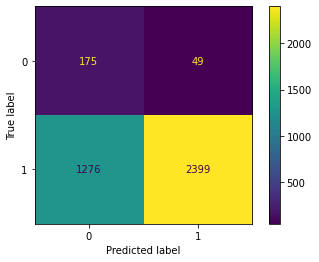

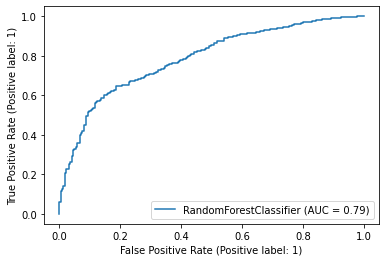

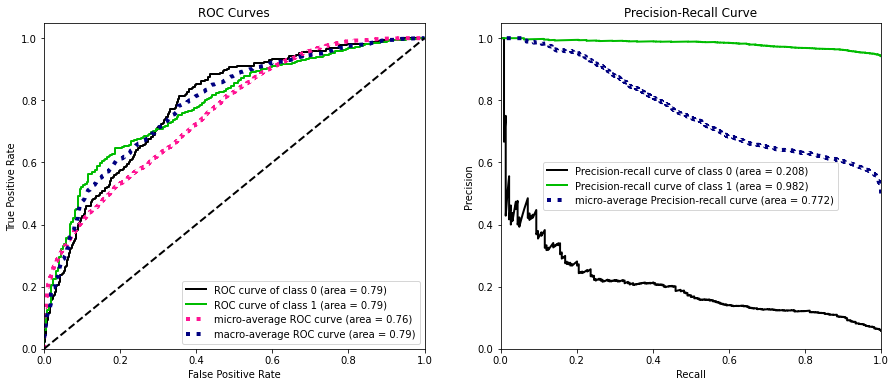

-------------------Train SVM----------------------
Confusion matrix 
 [[ 166   58]
 [1034 2641]]
Balance Accuracy= 0.7298554421768708
Class wise accuracy [0.74107143 0.71863946]
Per class accuracy class 1 0.7199281867145422
Per class accuracy class 0 0.7199281867145422
average per class  accuracy 0.7199281867145422
ClassificationReport 
               precision    recall  f1-score   support

           0       0.14      0.74      0.23       224
           1       0.98      0.72      0.83      3675

    accuracy                           0.72      3899
   macro avg       0.56      0.73      0.53      3899
weighted avg       0.93      0.72      0.79      3899

Scores [0.73490814 0.73490814 0.70263158 0.71315789 0.71315789] 0.7197527282773863
F1 weighted 0.7944652667954398
Precison weighted 0.9302418498861094
recall weighted 0.7199281867145422
Confusion matrix 



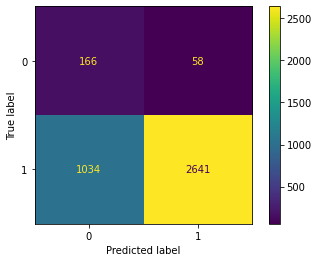

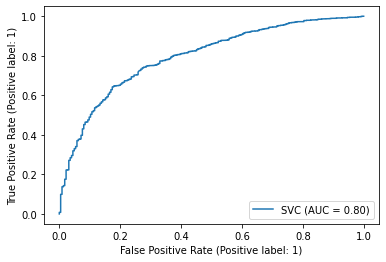

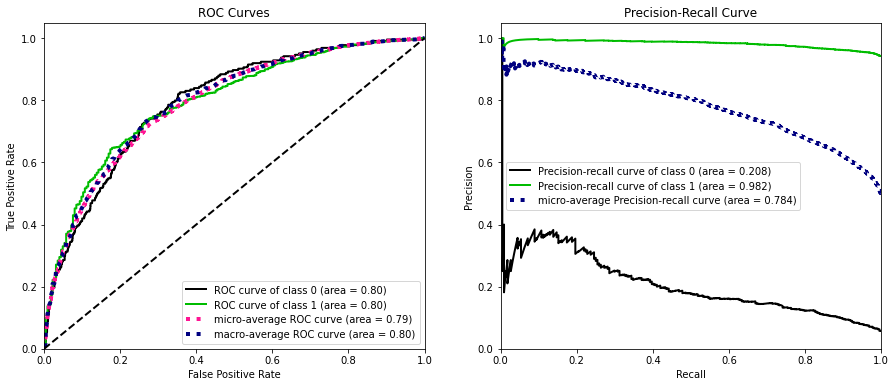

In [24]:
filepath='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/MFCC/II.csv'
print("file path--------------",filepath,"-------------")
df=pd.read_csv(filepath)
df.rename(columns={ df.columns[-1]: "label" }, inplace = True)  
## Normalize data
norm_data= normalize_data(df)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)
print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)

# III MFCC

file path-------------- ../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/MFCC/III.csv -------------
Numbers of class instances (Raw): {0: 6400, 1: 538}
Numbers of class instances (Raw): {0: 6400, 1: 538}
Length of train:  5550 Length of test : 1388
Numbers of class instances (Train): {0: 5126, 1: 424}
Numbers of class instances (Test): {0: 1274, 1: 114}
Length of train:  848 Length of label : 848
Numbers of class instances (Undersampling): {0: 424, 1: 424}
---------------Train Random forest----------------
Confusion matrix 
 [[1007  267]
 [  41   73]]
Balance Accuracy= 0.7153873695227079
Class wise accuracy [0.79042386 0.64035088]
Per class accuracy class 1 0.7780979827089337
Per class accuracy class 0 0.7780979827089337
average per class  accuracy 0.7780979827089337
ClassificationReport 
               precision    recall  f1-score   support

           0       0.96      0.79      0.87      1274
           1       0.21      0.64      0.32       114

    accura

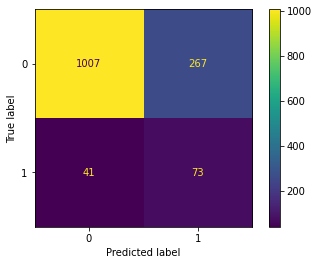

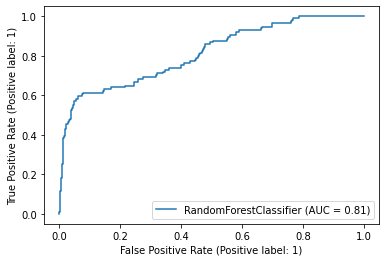

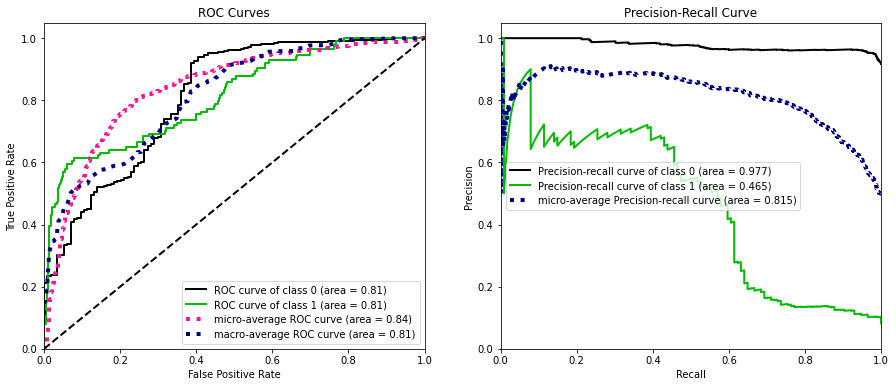

-------------------Train SVM----------------------
Confusion matrix 
 [[1008  266]
 [  27   87]]
Balance Accuracy= 0.7771833429728167
Class wise accuracy [0.79120879 0.76315789]
Per class accuracy class 1 0.7889048991354467
Per class accuracy class 0 0.7889048991354467
average per class  accuracy 0.7889048991354467
ClassificationReport 
               precision    recall  f1-score   support

           0       0.97      0.79      0.87      1274
           1       0.25      0.76      0.37       114

    accuracy                           0.79      1388
   macro avg       0.61      0.78      0.62      1388
weighted avg       0.91      0.79      0.83      1388

Scores [0.75294118 0.72941176 0.70588235 0.76331361 0.73372781] 0.7370553428471981
F1 weighted 0.8319967225906394
Precison weighted 0.914165370800978
recall weighted 0.7889048991354467
Confusion matrix 



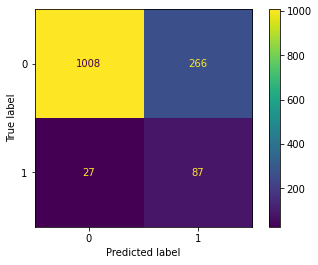

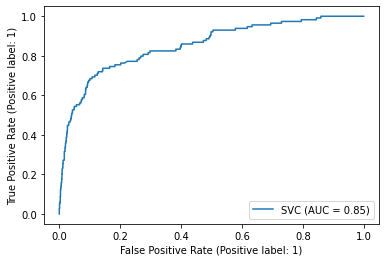

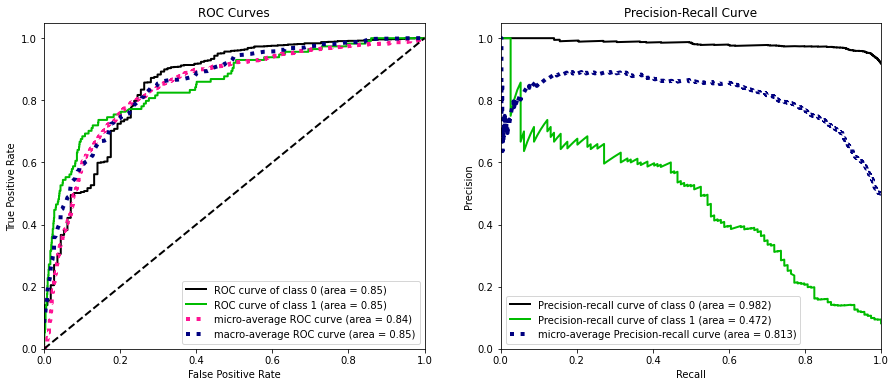

In [17]:
filepath='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/MFCC/III.csv'
print("file path--------------",filepath,"-------------")
df=pd.read_csv(filepath)
df.rename(columns={ df.columns[-1]: "label" }, inplace = True)  
## Normalize data
norm_data= normalize_data(df)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)
print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)

# IV MFCC

file path-------------- ../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/MFCC/IV.csv -------------
Numbers of class instances (Raw): {0: 16950, 1: 2651}
Numbers of class instances (Raw): {0: 16950, 1: 2651}
Length of train:  15680 Length of test : 3921
Numbers of class instances (Train): {0: 13564, 1: 2116}
Numbers of class instances (Test): {0: 3386, 1: 535}
Length of train:  4232 Length of label : 4232
Numbers of class instances (Undersampling): {0: 2116, 1: 2116}
---------------Train Random forest----------------
Confusion matrix 
 [[2564  822]
 [ 219  316]]
Balance Accuracy= 0.6739449409608558
Class wise accuracy [0.75723568 0.59065421]
Per class accuracy class 1 0.7345065034429993
Per class accuracy class 0 0.7345065034429993
average per class  accuracy 0.7345065034429993
ClassificationReport 
               precision    recall  f1-score   support

           0       0.92      0.76      0.83      3386
           1       0.28      0.59      0.38       535



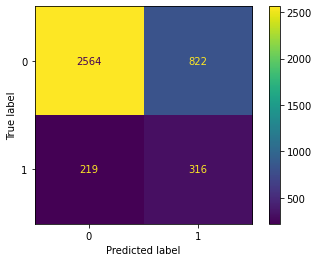

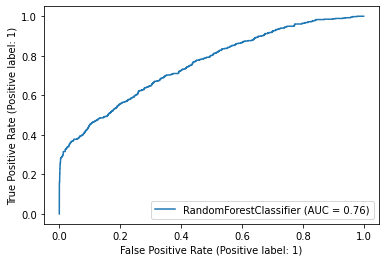

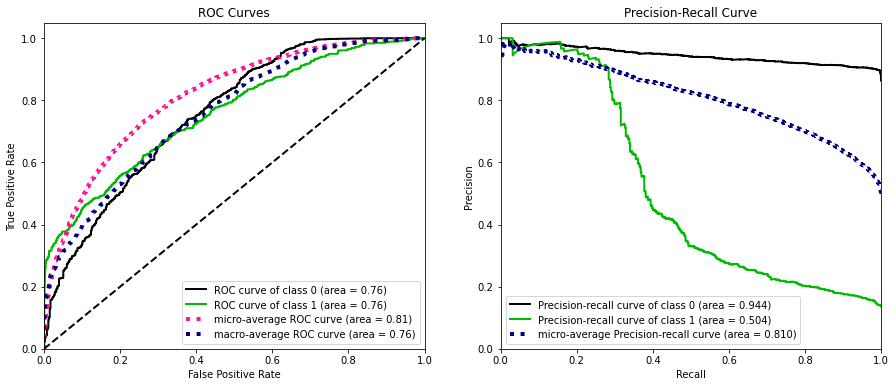

-------------------Train SVM----------------------
Confusion matrix 
 [[2387  999]
 [ 185  350]]
Balance Accuracy= 0.6795836070460555
Class wise accuracy [0.70496161 0.65420561]
Per class accuracy class 1 0.6980362152512114
Per class accuracy class 0 0.6980362152512114
average per class  accuracy 0.6980362152512114
ClassificationReport 
               precision    recall  f1-score   support

           0       0.93      0.70      0.80      3386
           1       0.26      0.65      0.37       535

    accuracy                           0.70      3921
   macro avg       0.59      0.68      0.59      3921
weighted avg       0.84      0.70      0.74      3921

Scores [0.68476978 0.66942149 0.69976359 0.69976359 0.66312057] 0.6833678034838576
F1 weighted 0.7426417650374445
Precison weighted 0.836841815004367
recall weighted 0.6980362152512114
Confusion matrix 



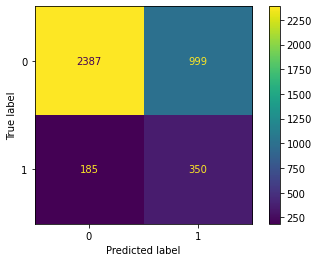

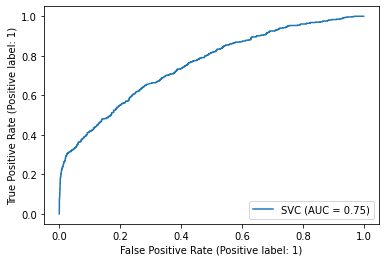

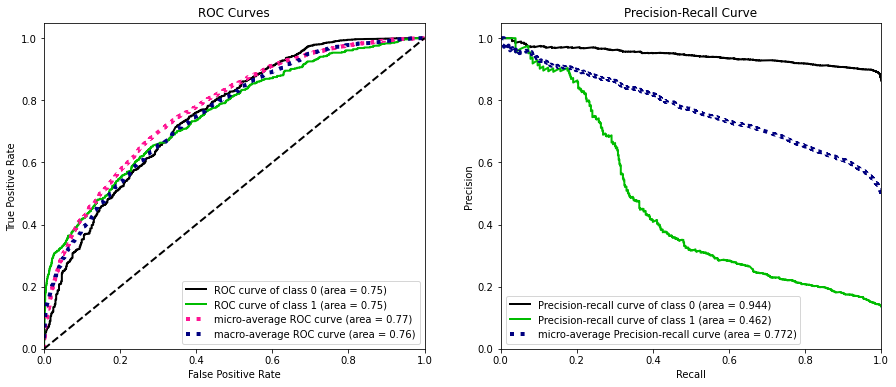

In [18]:
filepath='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/MFCC/IV.csv'
print("file path--------------",filepath,"-------------")
df=pd.read_csv(filepath)
df.rename(columns={ df.columns[-1]: "label" }, inplace = True)  
## Normalize data
norm_data= normalize_data(df)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)
print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)

# II PSD

file path-------------- ../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/PSD/II.csv -------------
Numbers of class instances (Raw): {0: 1175, 1: 18318}
Numbers of class instances (Raw): {0: 1175, 1: 18318}
Length of train:  15594 Length of test : 3899
Numbers of class instances (Train): {0: 951, 1: 14643}
Numbers of class instances (Test): {0: 224, 1: 3675}
Length of train:  1902 Length of label : 1902
Numbers of class instances (Undersampling): {0: 951, 1: 951}
---------------Train Random forest----------------
Confusion matrix 
 [[ 124  100]
 [1618 2057]]
Balance Accuracy= 0.5566496598639457
Class wise accuracy [0.55357143 0.55972789]
Per class accuracy class 1 0.5593741985124391
Per class accuracy class 0 0.5593741985124391
average per class  accuracy 0.5593741985124391
ClassificationReport 
               precision    recall  f1-score   support

           0       0.07      0.55      0.13       224
           1       0.95      0.56      0.71      3675

    

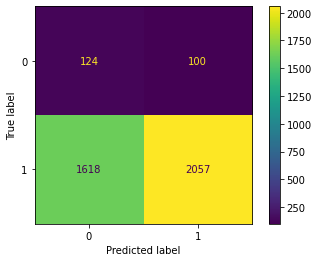

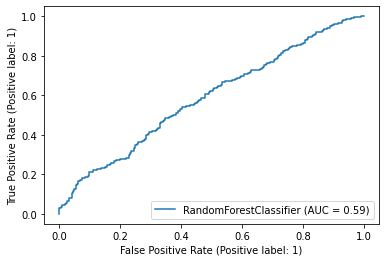

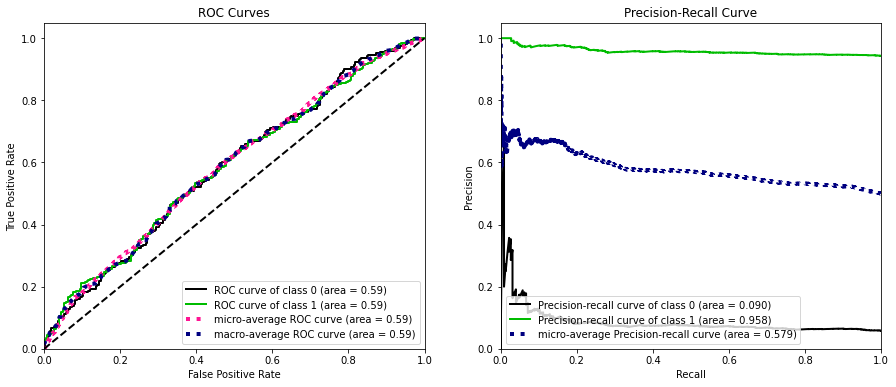

-------------------Train SVM----------------------
Confusion matrix 
 [[  40  184]
 [ 563 3112]]
Balance Accuracy= 0.5126870748299319
Class wise accuracy [0.17857143 0.84680272]
Per class accuracy class 1 0.8084124134393434
Per class accuracy class 0 0.8084124134393434
average per class  accuracy 0.8084124134393434
ClassificationReport 
               precision    recall  f1-score   support

           0       0.07      0.18      0.10       224
           1       0.94      0.85      0.89      3675

    accuracy                           0.81      3899
   macro avg       0.51      0.51      0.49      3899
weighted avg       0.89      0.81      0.85      3899

Scores [0.52230971 0.52493438 0.53947368 0.51578947 0.51052632] 0.5226067136344799
F1 weighted 0.8471049494685579
Precison weighted 0.8937423111444803
recall weighted 0.8084124134393434
Confusion matrix 



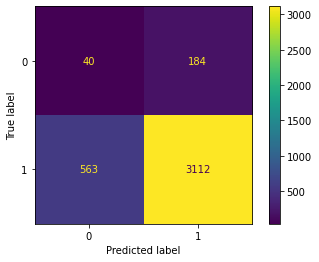

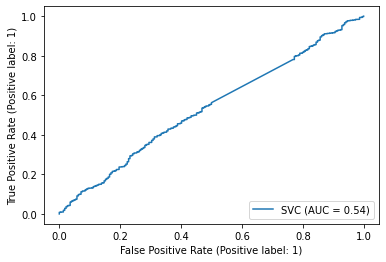

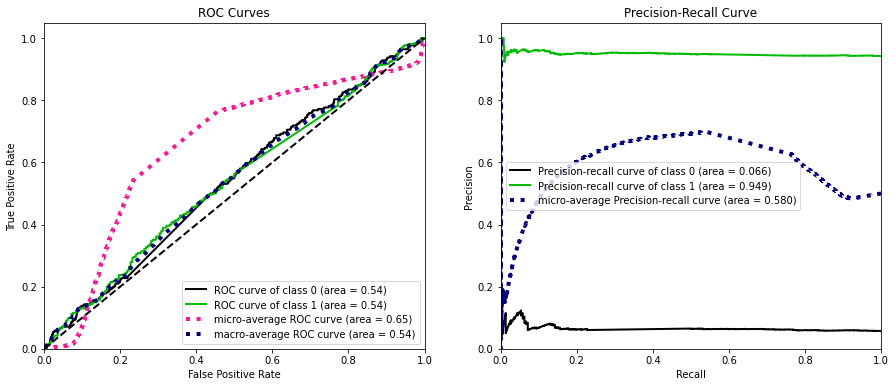

In [19]:
filepath='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/PSD/II.csv'
print("file path--------------",filepath,"-------------")
df=pd.read_csv(filepath)
df.rename(columns={ df.columns[-1]: "label" }, inplace = True)  
## Normalize data
norm_data= normalize_data(df)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)
print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)

# III PSD

file path-------------- ../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/PSD/III.csv -------------
Numbers of class instances (Raw): {0: 6400, 1: 538}
Numbers of class instances (Raw): {0: 6400, 1: 538}
Length of train:  5550 Length of test : 1388
Numbers of class instances (Train): {0: 5126, 1: 424}
Numbers of class instances (Test): {0: 1274, 1: 114}
Length of train:  848 Length of label : 848
Numbers of class instances (Undersampling): {0: 424, 1: 424}
---------------Train Random forest----------------
Confusion matrix 
 [[681 593]
 [ 42  72]]
Balance Accuracy= 0.5830579195240849
Class wise accuracy [0.53453689 0.63157895]
Per class accuracy class 1 0.542507204610951
Per class accuracy class 0 0.542507204610951
average per class  accuracy 0.542507204610951
ClassificationReport 
               precision    recall  f1-score   support

           0       0.94      0.53      0.68      1274
           1       0.11      0.63      0.18       114

    accuracy      

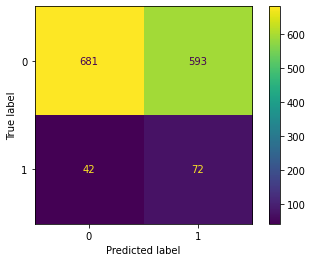

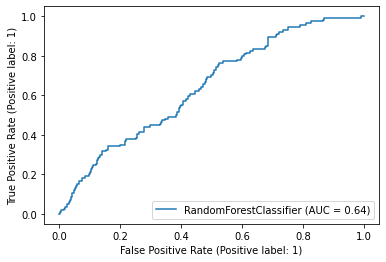

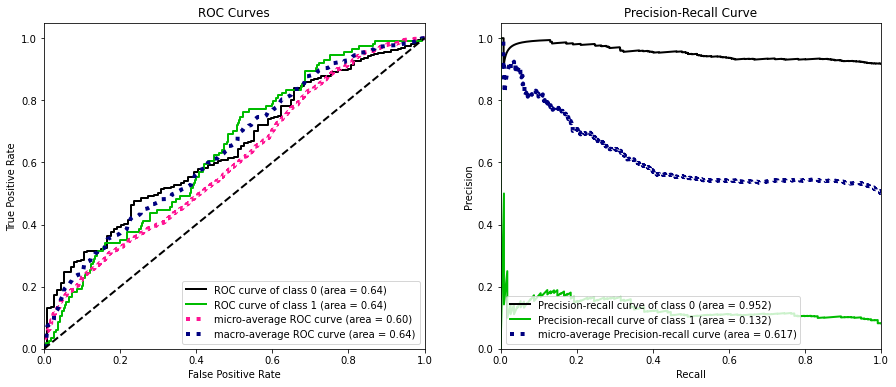

-------------------Train SVM----------------------
Confusion matrix 
 [[299 975]
 [ 11 103]]
Balance Accuracy= 0.5691013247404225
Class wise accuracy [0.23469388 0.90350877]
Per class accuracy class 1 0.2896253602305475
Per class accuracy class 0 0.2896253602305475
average per class  accuracy 0.2896253602305475
ClassificationReport 
               precision    recall  f1-score   support

           0       0.96      0.23      0.38      1274
           1       0.10      0.90      0.17       114

    accuracy                           0.29      1388
   macro avg       0.53      0.57      0.28      1388
weighted avg       0.89      0.29      0.36      1388

Scores [0.6        0.57647059 0.59411765 0.53254438 0.52071006] 0.564768534632788
F1 weighted 0.3607121858782788
Precison weighted 0.8931454911441365
recall weighted 0.2896253602305475
Confusion matrix 



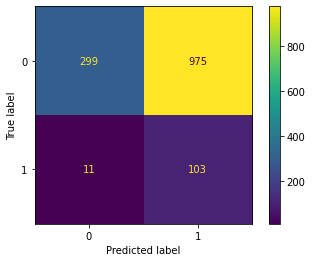

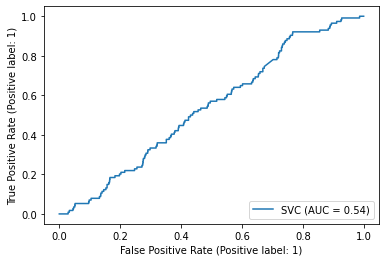

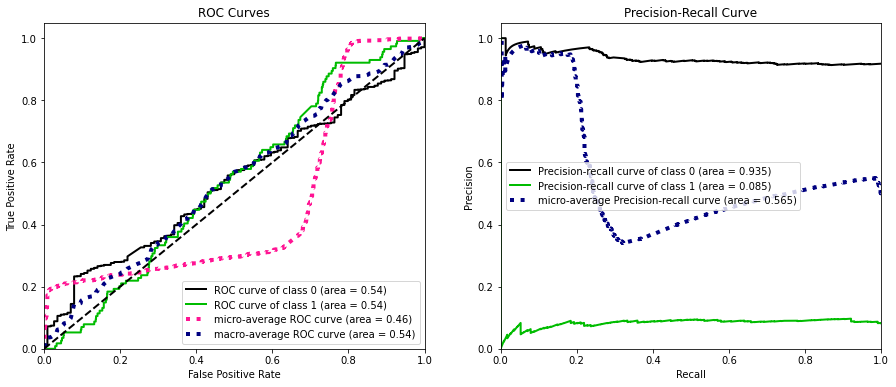

In [20]:
filepath='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/PSD/III.csv'
print("file path--------------",filepath,"-------------")
df=pd.read_csv(filepath)
df.rename(columns={ df.columns[-1]: "label" }, inplace = True)  
## Normalize data
norm_data= normalize_data(df)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)
print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)

# IV PSD

file path-------------- ../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/PSD/IV.csv -------------
Numbers of class instances (Raw): {0: 16950, 1: 2651}
Numbers of class instances (Raw): {0: 16950, 1: 2651}
Length of train:  15680 Length of test : 3921
Numbers of class instances (Train): {0: 13564, 1: 2116}
Numbers of class instances (Test): {0: 3386, 1: 535}
Length of train:  4232 Length of label : 4232
Numbers of class instances (Undersampling): {0: 2116, 1: 2116}
---------------Train Random forest----------------
Confusion matrix 
 [[2236 1150]
 [ 180  355]]
Balance Accuracy= 0.6619588078453886
Class wise accuracy [0.66036621 0.6635514 ]
Per class accuracy class 1 0.6608008161183372
Per class accuracy class 0 0.6608008161183372
average per class  accuracy 0.6608008161183372
ClassificationReport 
               precision    recall  f1-score   support

           0       0.93      0.66      0.77      3386
           1       0.24      0.66      0.35       535

 

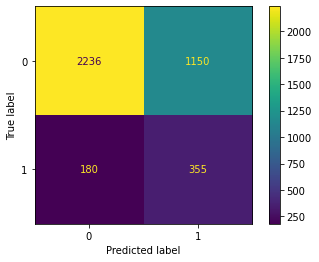

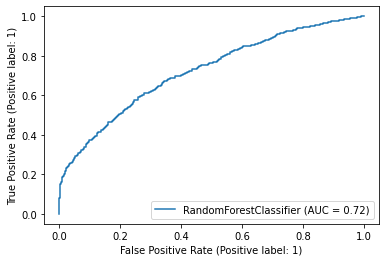

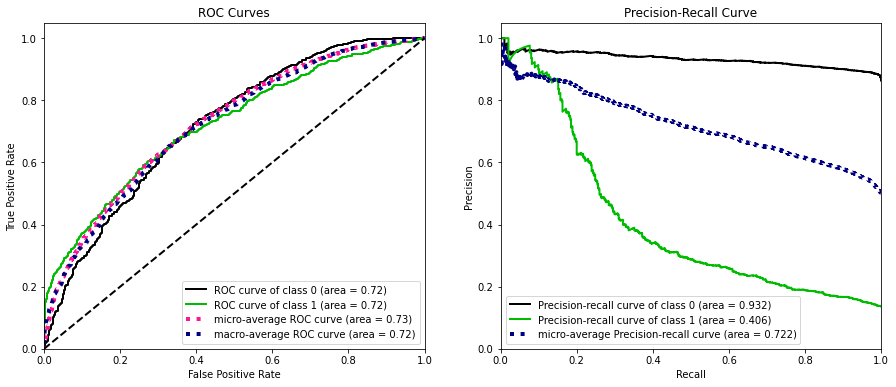

-------------------Train SVM----------------------
Confusion matrix 
 [[2243 1143]
 [ 212  323]]
Balance Accuracy= 0.6330859338342046
Class wise accuracy [0.66243355 0.60373832]
Per class accuracy class 1 0.6544248916092833
Per class accuracy class 0 0.6544248916092833
average per class  accuracy 0.6544248916092833
ClassificationReport 
               precision    recall  f1-score   support

           0       0.91      0.66      0.77      3386
           1       0.22      0.60      0.32       535

    accuracy                           0.65      3921
   macro avg       0.57      0.63      0.55      3921
weighted avg       0.82      0.65      0.71      3921

Scores [0.62101535 0.5974026  0.61465721 0.60756501 0.62529551] 0.6131871352374254
F1 weighted 0.7072766045775358
Precison weighted 0.8190459688476959
recall weighted 0.6544248916092833
Confusion matrix 



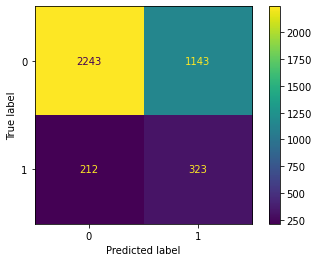

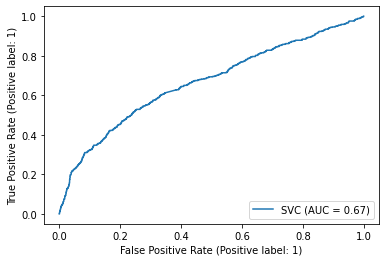

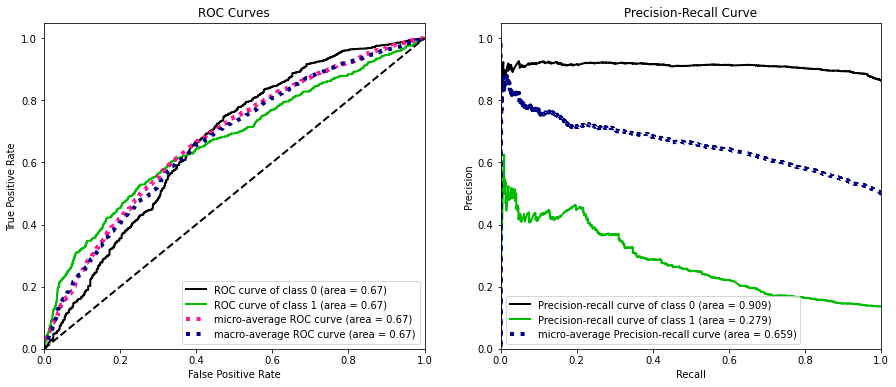

In [21]:
filepath='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/PSD/IV.csv'
print("file path--------------",filepath,"-------------")
df=pd.read_csv(filepath)
df.rename(columns={ df.columns[-1]: "label" }, inplace = True)  
## Normalize data
norm_data= normalize_data(df)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)
print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)

# IV (Time and PSD)

(19601, 20) (19601, 6)
(19601, 25)
Numbers of class instances (Raw): {0: 16950, 1: 2651}
Numbers of class instances (Raw): {0: 16950, 1: 2651}
Length of train:  15680 Length of test : 3921
Numbers of class instances (Train): {0: 13564, 1: 2116}
Numbers of class instances (Test): {0: 3386, 1: 535}
Length of train:  4232 Length of label : 4232
Numbers of class instances (Undersampling): {0: 2116, 1: 2116}
---------------Train Random forest----------------
Confusion matrix 
 [[2595  791]
 [ 153  382]]
Balance Accuracy= 0.7402048567217404
Class wise accuracy [0.76639102 0.71401869]
Per class accuracy class 1 0.759245090538128
Per class accuracy class 0 0.759245090538128
average per class  accuracy 0.759245090538128
ClassificationReport 
               precision    recall  f1-score   support

           0       0.94      0.77      0.85      3386
           1       0.33      0.71      0.45       535

    accuracy                           0.76      3921
   macro avg       0.63      0.74     

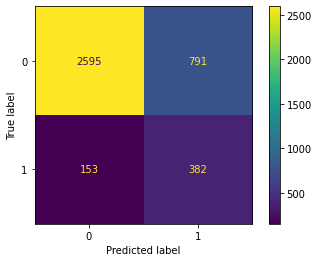

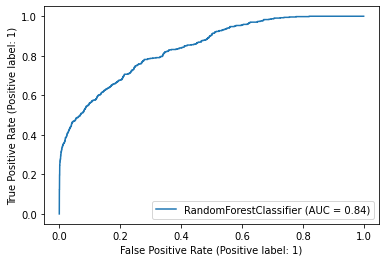

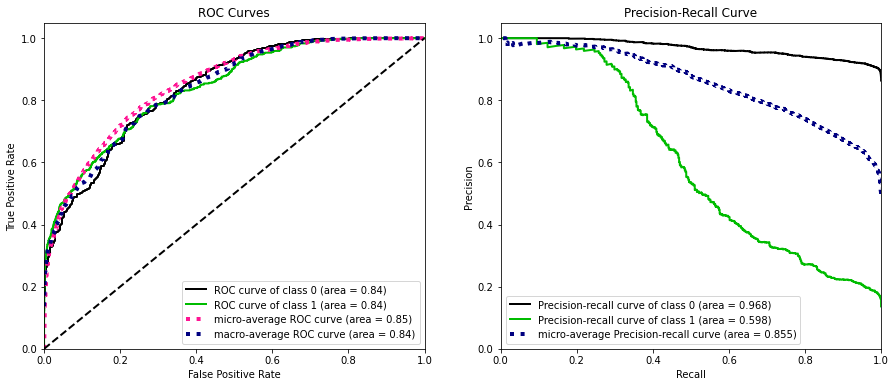

-------------------Train SVM----------------------
Confusion matrix 
 [[3073  313]
 [ 289  246]]
Balance Accuracy= 0.6836868137631037
Class wise accuracy [0.90756054 0.45981308]
Per class accuracy class 1 0.8464677378219841
Per class accuracy class 0 0.8464677378219841
average per class  accuracy 0.8464677378219841
ClassificationReport 
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      3386
           1       0.44      0.46      0.45       535

    accuracy                           0.85      3921
   macro avg       0.68      0.68      0.68      3921
weighted avg       0.85      0.85      0.85      3921

Scores [0.65053129 0.66233766 0.67612293 0.6678487  0.63593381] 0.6585548773169664
F1 weighted 0.8478787939957484
Precison weighted 0.8493688408426007
recall weighted 0.8464677378219841
Confusion matrix 



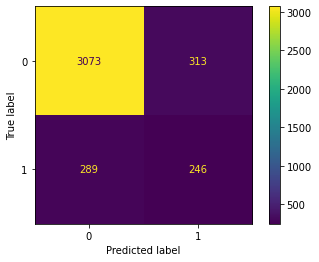

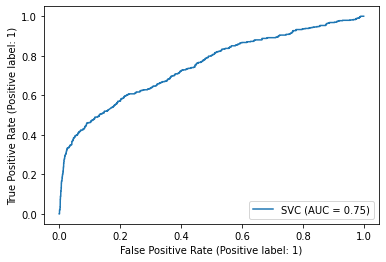

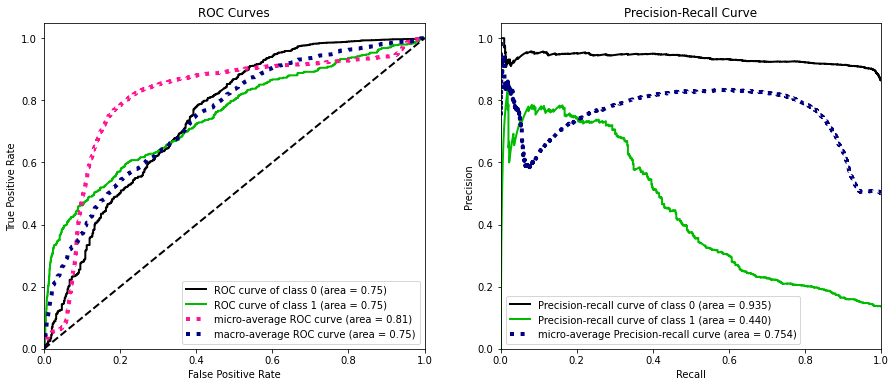

In [12]:
filepath1='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/Time/IV.csv'
filepath2='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/PSD/IV.csv'

df1=pd.read_csv(filepath1)
df2=pd.read_csv(filepath2)

df1.rename(columns={ df1.columns[-1]: "label" }, inplace = True)  
df2.rename(columns={ df2.columns[-1]: "label" }, inplace = True)  
print(df1.shape,df2.shape)

df3=pd.concat([df1.iloc[:,:-1],df2.iloc[:,:-1],df1.iloc[:,-1:]],axis=1,ignore_index=False)
print(df3.shape)

## Normalize data
norm_data= normalize_data(df3)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)
print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)

# II TIME +PSD

(19493, 20) (19493, 6)
(19493, 25)
Numbers of class instances (Raw): {0: 1175, 1: 18318}
Numbers of class instances (Raw): {0: 1175, 1: 18318}
Length of train:  15594 Length of test : 3899
Numbers of class instances (Train): {0: 951, 1: 14643}
Numbers of class instances (Test): {0: 224, 1: 3675}
Length of train:  1902 Length of label : 1902
Numbers of class instances (Undersampling): {0: 951, 1: 951}
---------------Train Random forest----------------
Confusion matrix 
 [[ 173   51]
 [1232 2443]]
Balance Accuracy= 0.7185416666666666
Class wise accuracy [0.77232143 0.6647619 ]
Per class accuracy class 1 0.6709412669915363
Per class accuracy class 0 0.6709412669915363
average per class  accuracy 0.6709412669915363
ClassificationReport 
               precision    recall  f1-score   support

           0       0.12      0.77      0.21       224
           1       0.98      0.66      0.79      3675

    accuracy                           0.67      3899
   macro avg       0.55      0.72     

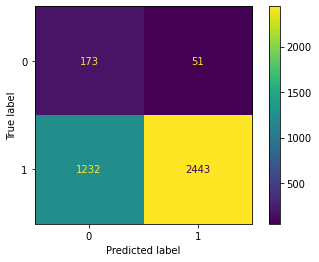

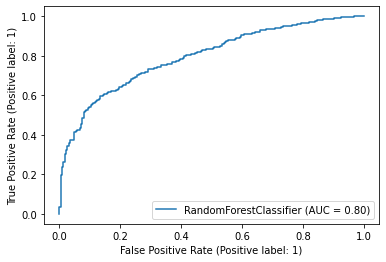

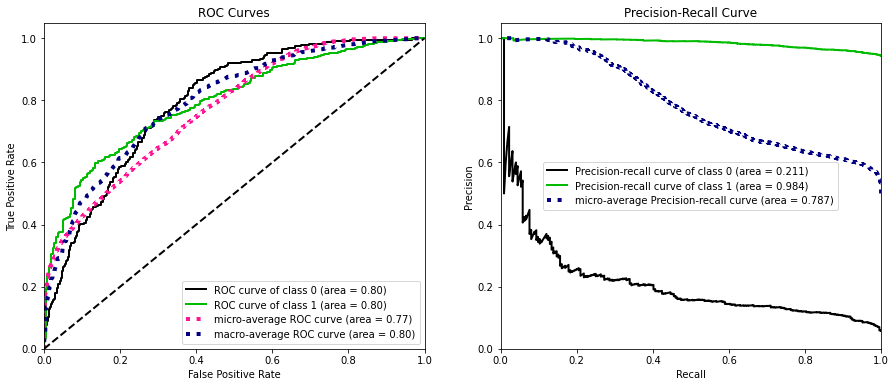

-------------------Train SVM----------------------
Confusion matrix 
 [[ 187   37]
 [1595 2080]]
Balance Accuracy= 0.7004039115646259
Class wise accuracy [0.83482143 0.56598639]
Per class accuracy class 1 0.5814311361887663
Per class accuracy class 0 0.5814311361887663
average per class  accuracy 0.5814311361887663
ClassificationReport 
               precision    recall  f1-score   support

           0       0.10      0.83      0.19       224
           1       0.98      0.57      0.72      3675

    accuracy                           0.58      3899
   macro avg       0.54      0.70      0.45      3899
weighted avg       0.93      0.58      0.69      3899

Scores [0.67454068 0.70866142 0.63421053 0.67105263 0.70263158] 0.6782193673159276
F1 weighted 0.6876802960490758
Precison weighted 0.9321046756415788
recall weighted 0.5814311361887663
Confusion matrix 



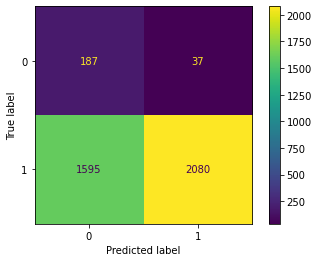

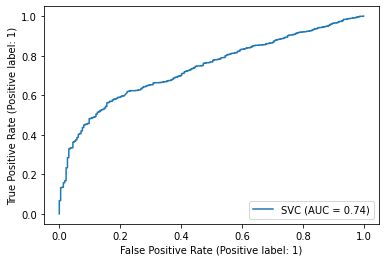

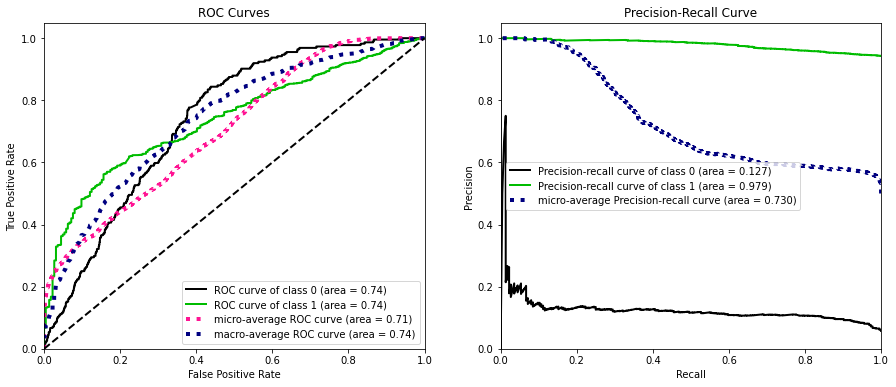

In [13]:
filepath1='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/Time/II.csv'
filepath2='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/PSD/II.csv'

df1=pd.read_csv(filepath1)
df2=pd.read_csv(filepath2)

df1.rename(columns={ df1.columns[-1]: "label" }, inplace = True)  
df2.rename(columns={ df2.columns[-1]: "label" }, inplace = True)  
print(df1.shape,df2.shape)

df3=pd.concat([df1.iloc[:,:-1],df2.iloc[:,:-1],df1.iloc[:,-1:]],axis=1,ignore_index=False)
print(df3.shape)

## Normalize data
norm_data= normalize_data(df3)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)
print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)

# III TIME +PSD

(6938, 20) (6938, 6)
(6938, 25)
Numbers of class instances (Raw): {0: 6400, 1: 538}
Numbers of class instances (Raw): {0: 6400, 1: 538}
Length of train:  5550 Length of test : 1388
Numbers of class instances (Train): {0: 5126, 1: 424}
Numbers of class instances (Test): {0: 1274, 1: 114}
Length of train:  848 Length of label : 848
Numbers of class instances (Undersampling): {0: 424, 1: 424}
---------------Train Random forest----------------
Confusion matrix 
 [[991 283]
 [ 37  77]]
Balance Accuracy= 0.7266517943209673
Class wise accuracy [0.77786499 0.6754386 ]
Per class accuracy class 1 0.7694524495677233
Per class accuracy class 0 0.7694524495677233
average per class  accuracy 0.7694524495677233
ClassificationReport 
               precision    recall  f1-score   support

           0       0.96      0.78      0.86      1274
           1       0.21      0.68      0.32       114

    accuracy                           0.77      1388
   macro avg       0.59      0.73      0.59      1388

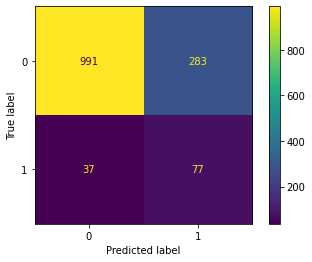

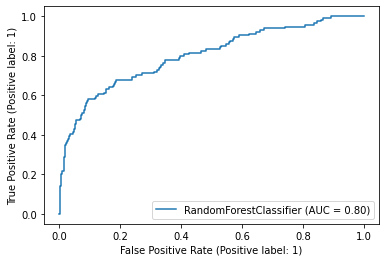

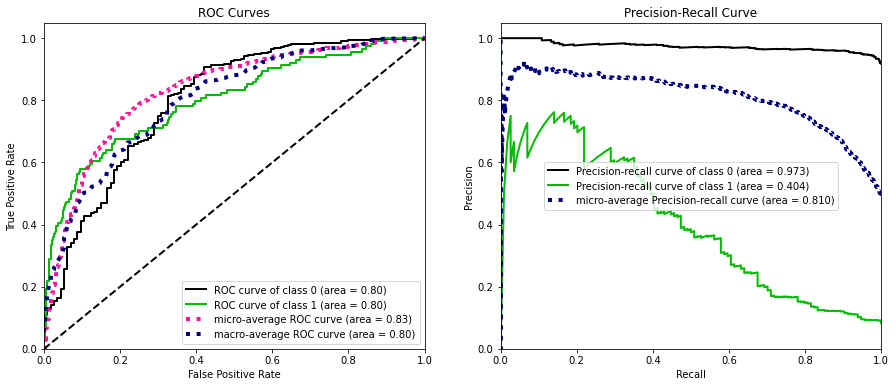

-------------------Train SVM----------------------
Confusion matrix 
 [[821 453]
 [ 46  68]]
Balance Accuracy= 0.620459114820017
Class wise accuracy [0.644427   0.59649123]
Per class accuracy class 1 0.6404899135446686
Per class accuracy class 0 0.6404899135446686
average per class  accuracy 0.6404899135446686
ClassificationReport 
               precision    recall  f1-score   support

           0       0.95      0.64      0.77      1274
           1       0.13      0.60      0.21       114

    accuracy                           0.64      1388
   macro avg       0.54      0.62      0.49      1388
weighted avg       0.88      0.64      0.72      1388

Scores [0.66470588 0.63529412 0.64705882 0.61538462 0.63313609] 0.6391159067177166
F1 weighted 0.7215318990073832
Precison weighted 0.8798883835648506
recall weighted 0.6404899135446686
Confusion matrix 



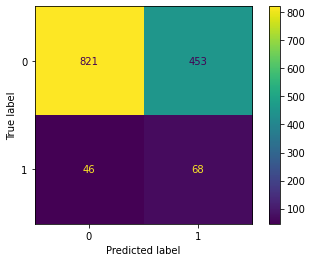

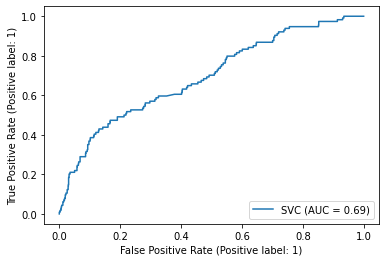

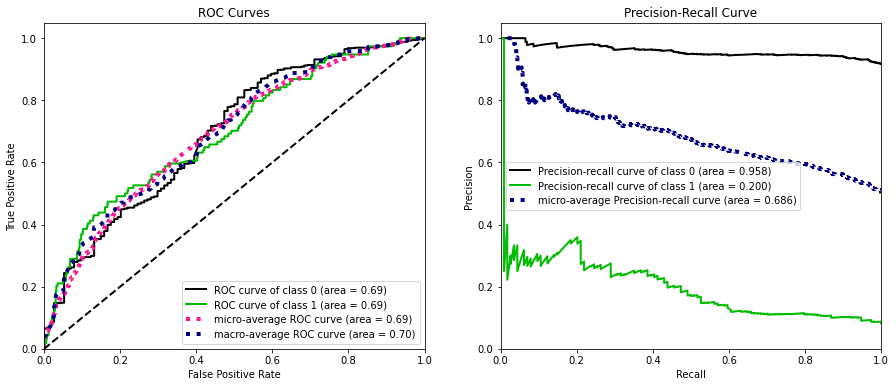

In [14]:
filepath1='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/Time/III.csv'
filepath2='../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/PSD/III.csv'

df1=pd.read_csv(filepath1)
df2=pd.read_csv(filepath2)

df1.rename(columns={ df1.columns[-1]: "label" }, inplace = True)  
df2.rename(columns={ df2.columns[-1]: "label" }, inplace = True)  
print(df1.shape,df2.shape)

df3=pd.concat([df1.iloc[:,:-1],df2.iloc[:,:-1],df1.iloc[:,-1:]],axis=1,ignore_index=False)
print(df3.shape)

## Normalize data
norm_data= normalize_data(df3)

## Separate data and label
label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
data=np.array(norm_data.iloc[:,:-1])

unique, counts = np.unique(label, return_counts=True)
d=dict(zip(unique, counts))
print(f"Numbers of class instances (Raw): {d}")

# partition data
x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

print("Length of train: ", len(x_train),"Length of test :", len(x_test))

unique, counts = np.unique(y_train, return_counts=True)
d1=dict(zip(unique, counts))
print(f"Numbers of class instances (Train): {d1}")

unique, counts = np.unique(y_test, return_counts=True)
d2=dict(zip(unique, counts))
print(f"Numbers of class instances (Test): {d2}")

undersample_data, undersample_label=undersampling(x_train,y_train)

print("---------------Train Random forest----------------")
model=train_model(undersample_data, undersample_label,'Random')
evaluation_matrix(model,undersample_data, undersample_label,x_test,y_test)
print("-------------------Train SVM----------------------")
model1=train_model(undersample_data, undersample_label,'SVM')
evaluation_matrix(model1,undersample_data, undersample_label,x_test,y_test)

In [15]:
import sklearn
print(sklearn.__version__)
sklearn.metrics.get_scorer_names()

1.1.2


['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_